In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# import data
adata = sc.read_10x_mtx('dataset/HCL_prostate', cache = True)
adata.obs['sample'] = 'HCL_prostate'
adata.obs['pool'] = 'HCL_prostate'
adata.obs['barcode'] = 'HCL_prostate'
adata.obs['patient'] = 'HCL_prostate'
adata.obs['name'] = 'HCL_prostate'
adata.obs['group'] = 'normal'
adata.obs['age'] = '45'
adata.obs['psa'] = '0'
adata.obs['highest_GLEASON_score'] = '0'
# rename cells to sample id + barcode, cleaving the trailing -1
adata.obs_names = ['HCL_prostate_'+str(j).split('-')[0] for j in adata.obs_names]
adata

... reading from cache file cache/dataset-HCL_prostate-matrix.h5ad


Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 10000 × 20424 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score'
    var: 'gene_ids', 'feature_types'

In [4]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

# run Krystoff's doublet caller
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']

dir = 'scrublet-scores'
if not os.path.exists(dir):
    os.makedirs(dir)

In [6]:
adata_scrub = adata.copy()
scrub = scr.Scrublet(adata_scrub.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
adata_scrub.obs['scrublet_score'] = doublet_scores
# overcluster prep. run turbo basic scanpy pipeline
sc.pp.filter_genes(adata_scrub, min_cells=3)
sc.pp.normalize_per_cell(adata_scrub, counts_per_cell_after=1e4)
sc.pp.log1p(adata_scrub)
sc.pp.highly_variable_genes(adata_scrub, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_scrub = adata_scrub[:, adata_scrub.var['highly_variable']]
sc.pp.scale(adata_scrub, max_value=10)
sc.tl.pca(adata_scrub, svd_solver='arpack')
sc.pp.neighbors(adata_scrub)
# overclustering proper - do basic clustering first, then cluster each cluster
sc.tl.leiden(adata_scrub)
for clus in np.unique(adata_scrub.obs['leiden']):
    sc.tl.leiden(adata_scrub, restrict_to=('leiden',[clus]))
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
for clus in np.unique(adata_scrub.obs['leiden']):
    adata_scrub.obs.loc[adata_scrub.obs['leiden']==clus, 'scrublet_cluster_score'] = \
        np.median(adata_scrub.obs.loc[adata_scrub.obs['leiden']==clus, 'scrublet_score'])
# now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
med = np.median(adata_scrub.obs['scrublet_cluster_score'])
mask = adata_scrub.obs['scrublet_cluster_score']>med
mad = np.median(adata_scrub.obs['scrublet_cluster_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata_scrub.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
adata_scrub.obs['bh_pval'] = bh(pvals)
# create results data frame for single sample and copy stuff over from the adata object
scrublet_sample = pd.DataFrame(0, index=adata_scrub.obs_names, columns=scorenames)
for meta in scorenames:
    scrublet_sample[meta] = adata_scrub.obs[meta]
# write out complete sample scores
scrublet_sample.to_csv('scrublet-scores/HCL_prostate.csv')

filtered out 4512 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.

In [7]:
scrdf = pd.read_csv('scrublet-scores/HCL_prostate.csv', header=0, index_col=0)
for meta in scorenames:
    adata.obs[meta] = scrdf[meta]

In [8]:
# threshold the p-values to get doublet calls.
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.05
adata.obs['is_doublet'] = adata.obs['is_doublet'].astype('category')

In [9]:
# check size of adata
adata

AnnData object with n_obs × n_vars = 10000 × 20424 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids', 'feature_types'

In [10]:
# continue with the standard analysis first to visualise what's the doublet calling rate
adata_raw = adata.copy()
# filter cells based on standard cut offs
sc.pp.filter_cells(adata_raw, min_genes = 200)
sc.pp.filter_genes(adata_raw, min_cells = 3)
# get mitochondria QC stats
mito_genes = adata_raw.var_names.str.startswith('mt-')
adata_raw.obs['percent_mito'] = np.sum(adata_raw[:, mito_genes].X, axis = 1) / np.sum(adata_raw.X, axis = 1)
adata_raw.obs['n_counts'] = adata_raw.X.sum(axis = 1)
# filtering
adata_raw = adata_raw[adata_raw.obs['n_genes'] < 2500, :]
adata_raw = adata_raw[adata_raw.obs['percent_mito'] < 0.3, :] # relatively high because of epithelial cells
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=1e4)
# Logarithmize the data
sc.pp.log1p(adata_raw)
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata_raw, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# Actually do the filtering.
adata_raw = adata_raw[:, adata_raw.var['highly_variable']]
import multiprocessing
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata_raw, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count()-1)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_raw, max_value = 10)
# Principal component analysis
sc.tl.pca(adata_raw, svd_solver = 'arpack')
# rerun umap and clusters
sc.pp.neighbors(adata_raw, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_raw, n_components = 2, min_dist = 0.3)
adata_raw

filtered out 4564 cells that have less than 200 genes expressed
filtered out 5277 genes that are detected in less than 3 cells
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'pool' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'barcode' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'patient' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'name' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'age' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'psa' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'highest_GLEASON_score' as categorical
Trying to set attribute `.var` of view, making a copy.
... storing 'feature_types' as categorical


    finished (0:00:57)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


AnnData object with n_obs × n_vars = 5436 × 2946 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

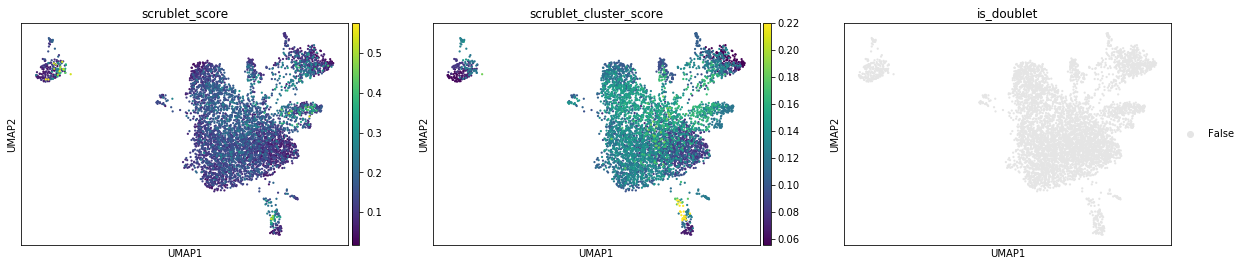

AnnData object with n_obs × n_vars = 5436 × 2946 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'is_doublet_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [11]:
# visualise the doublets
adata_raw.uns['is_doublet_colors'] = ['#e5e5e5', '#e15759']
sc.pl.umap(adata_raw, color = ['scrublet_score', 'scrublet_cluster_score', 'is_doublet'], size = 20)
adata_raw

In [12]:
# clear the unneeded objects
del adata_raw

In [13]:
# now, actually remove doublets and rerun everything
adata = adata[adata.obs['is_doublet'] != True]
adata

View of AnnData object with n_obs × n_vars = 10000 × 20424 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


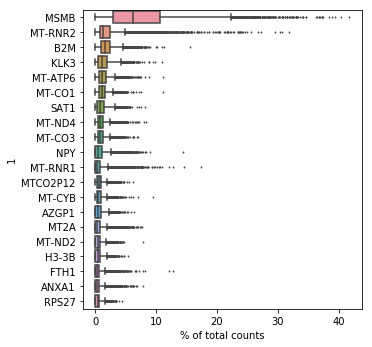

In [14]:
# continue with the standard analysis first
sc.settings.verbosity = 3
# plot higest expr genes
sc.pl.highest_expr_genes(adata, n_top = 20)

In [15]:
# filter cells based on standard cut offs
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)
adata

filtered out 4564 cells that have less than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 5277 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 5436 × 15147 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [16]:
# get mitochondria QC stats
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['n_counts'] = adata.X.sum(axis = 1)

... storing 'sample' as categorical
... storing 'pool' as categorical
... storing 'barcode' as categorical
... storing 'patient' as categorical
... storing 'name' as categorical
... storing 'group' as categorical
... storing 'age' as categorical
... storing 'psa' as categorical
... storing 'highest_GLEASON_score' as categorical
... storing 'feature_types' as categorical


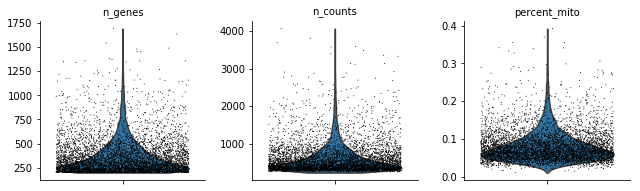

In [17]:
# violin plot of the computed quality measures.
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter = 0.4, multi_panel = True)

In [18]:
# final filtering
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]
adata

View of AnnData object with n_obs × n_vars = 5426 × 15147 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [19]:
# median genes
adata.obs.n_genes.median()

307.0

In [20]:
# median nUMI
adata.obs.n_counts.median()

469.0

In [21]:
# set aside a copy as raw before continuing
adata_raw = adata.copy()
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata)
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. 
adata.raw = adata

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:04)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


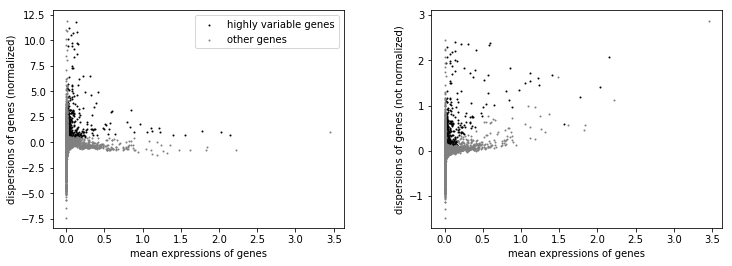

In [22]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [23]:
s_genes = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
g2m_genes = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [24]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


    finished (0:00:05)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


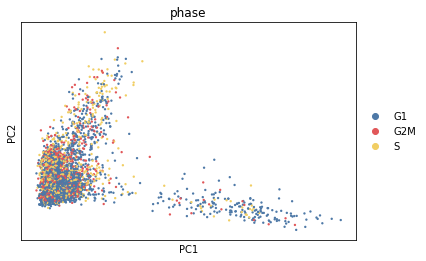

In [25]:
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_scatter(adata, color=['phase'], palette = ['#4e79a7', '#e15759', '#f1ce63'])

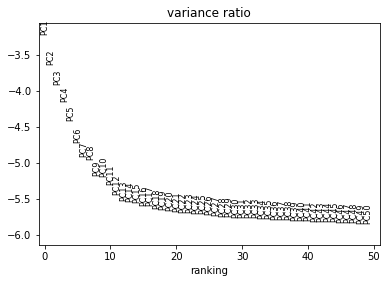

In [26]:
# Principal component analysis
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


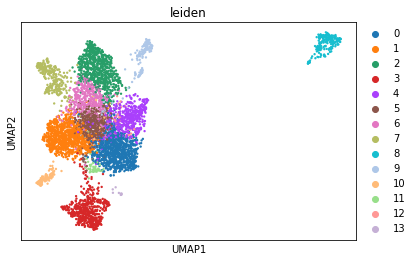

In [27]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata)
# plotting groups and clusters
sc.pl.umap(adata, color = ['leiden'])

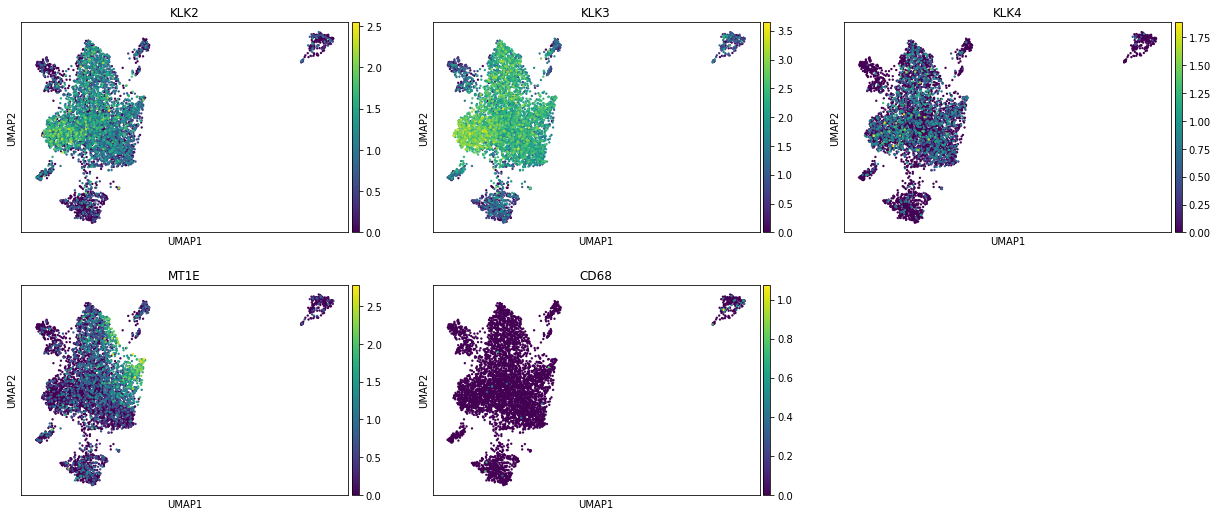

In [33]:
# check some expression
sc.pl.umap(adata, color = ['KLK2', 'KLK3', 'KLK4', 'MT1E', 'CD68'], ncols = 3)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


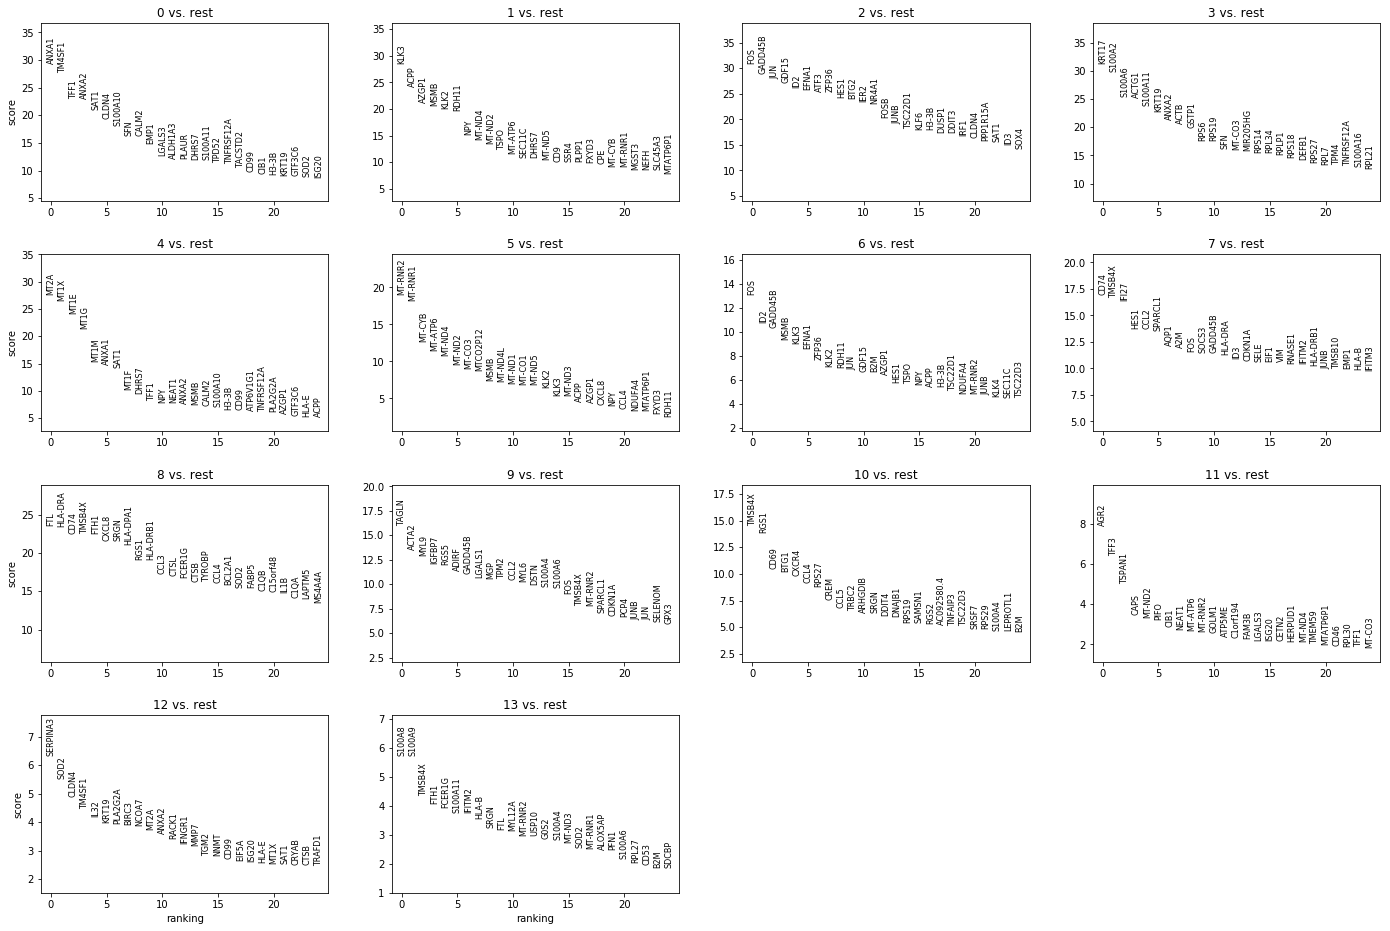

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
# save this file
results_file = 'dataset/prostate_hcl.h5ad'
adata.write(results_file, compression = 'gzip')

In [35]:
# also create a version to copy to seurat
results_file2 = 'dataset/prostate_hcl_raw.h5ad'
# Set the .raw attribute of AnnData object to the raw gene expression before normalizing
adata_raw.raw = adata_raw
# normalize matrix X to 10000 reads per cell
sc.pp.normalize_total(adata_raw)
# Logarithmize the data
sc.pp.log1p(adata_raw)
# transfer the adata meta info to adata_raw
adata_raw.obs = adata.obs
adata_raw.obsm = adata.obsm
adata_raw.uns = adata.uns
# save this new file
adata_raw.write(results_file2, compression='gzip')

normalizing counts per cell
    finished (0:00:00)


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'dataset/prostate_hcl.h5ad'
adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 5426 × 491 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
# subset to mnps
adata = adata[adata.obs['leiden']=='8']
adata

View of AnnData object with n_obs × n_vars = 211 × 491 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

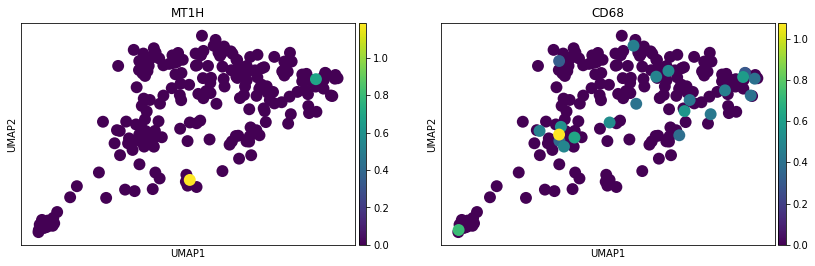

In [5]:
sc.pl.umap(adata, color = ['MT1H', '''CD68'])

In [6]:
mnp_file = 'dataset/prostate_hcl_mnp.h5ad'
adata.write(mnp_file, compression = 'gzip')

In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

mnp_file = 'dataset/prostate_hcl_mnp.h5ad'
adata = sc.read_h5ad(mnp_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 211 × 491 
    obs: 'sample', 'pool', 'barcode', 'patient', 'name', 'group', 'age', 'psa', 'highest_GLEASON_score', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'Mac1_score', 'Mac2_score', 'Mac-MT1_score', 'Mono_score', 'DC_score', 'Mac-cycling_score'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [8]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [9]:
# now compute Mac-MT1 score p-values. figure out the global median and mad (from above-median values) for the distribution for each celltype
med = np.median(adata.obs['Mac-MT1_score'])
mask = adata.obs['Mac-MT1_score']>med
mad = np.median(adata.obs['Mac-MT1_score'][mask]-med)
# do a one-sided test with Krystoff's implementation
pvals = 1-scipy.stats.norm.cdf(adata.obs['Mac-MT1_score'], loc=med, scale=1.4826*mad)
adata.obs['bh_pval'] = bh(pvals)

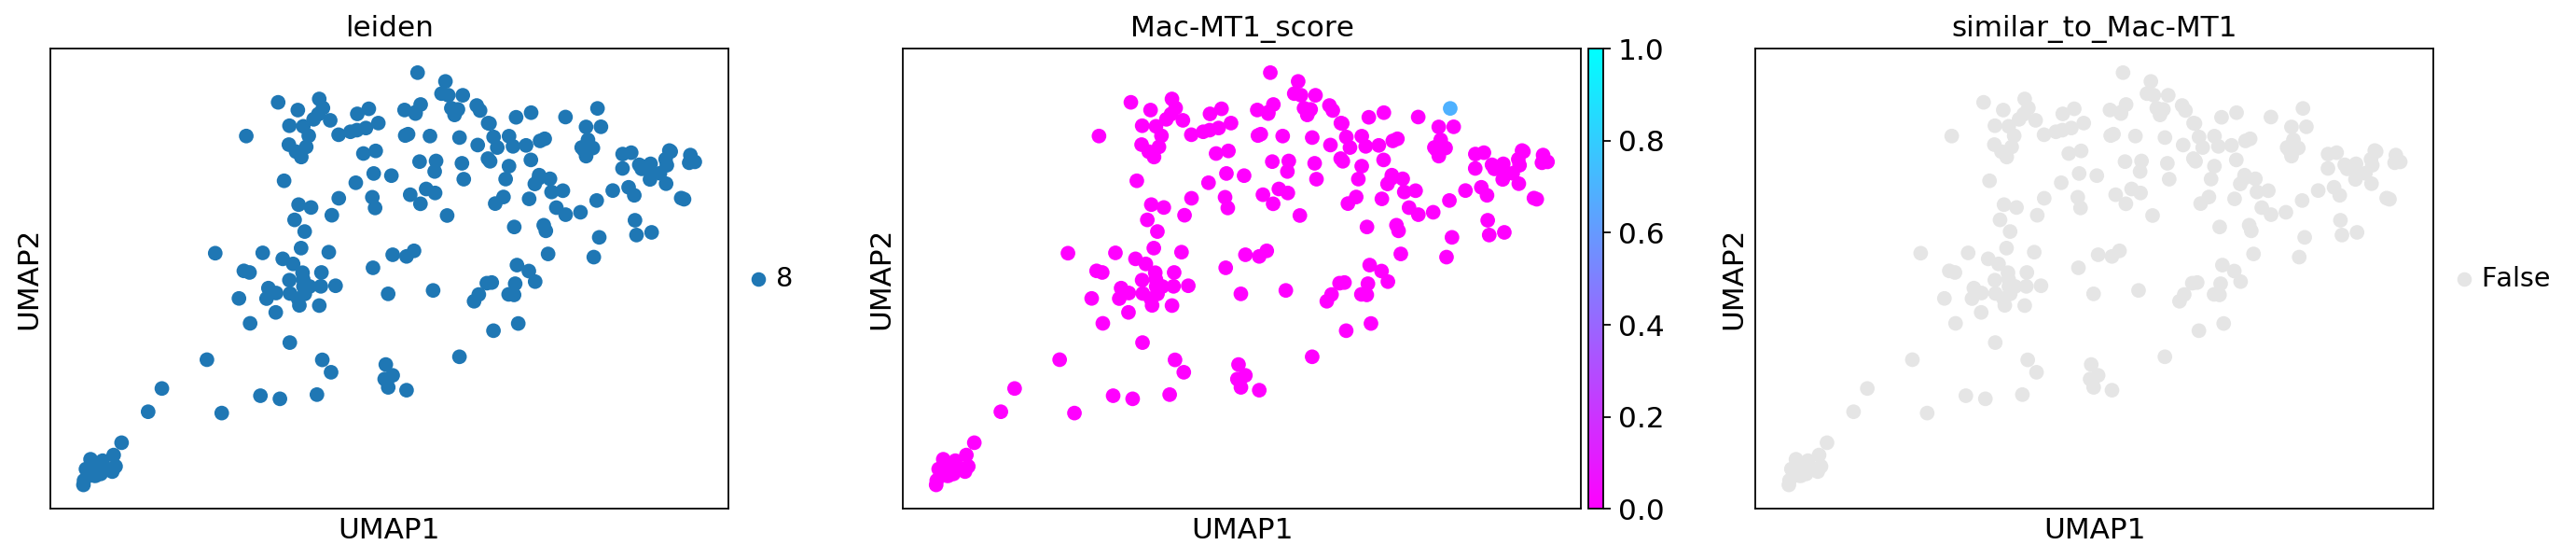

In [10]:
# threshold the p-values to get potential Mac-MT1 calls.
adata.obs['similar_to_Mac-MT1'] = (adata.obs['bh_pval'] < 0.05) & (adata.obs['Mac-MT1_score'] > 0.7)
adata.obs['similar_to_Mac-MT1'] = adata.obs['similar_to_Mac-MT1'].astype('category')
# visualise the Mac-MT1
adata.uns['similar_to_Mac-MT1_colors'] = ['#e5e5e5', '#e15759']
sc.set_figure_params(figsize = [6.0, 4.0], vector_friendly = True, dpi_save = 900)
sc.pl.umap(adata, color = ['leiden','Mac-MT1_score', 'similar_to_Mac-MT1'], size = 200, save = '/HCL_similarity_to_Mac-MT1.pdf', color_map = 'cool_r', vmax = 1)